In [103]:
import pandas as pd
import attr
import numpy as np
import geopandas as gpd
import os
from shapely.affinity import scale
from shapely.geometry import Point, Polygon
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import DataFrame as DF, Series as S
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from peakutils import baseline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression  # noqa: E402
from sklearn.ensemble import (  # noqa: E402
    ExtraTreesRegressor,  # noqa: E402
)
from scipy.signal import savgol_filter
import funcy
import random
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from caching import Cache
from sklearn.cluster import KMeans
import seaborn as sns
from functools import lru_cache, reduce
from custom_split import GroupKFold, StratifiedKFold, KFold
import scipy
import geopandas as gpd
from scipy.stats import skew


# TODO EDA
-  histograms
- correlations
- map USA


In [3]:
DEV = False
DEBUG = True
cached = Cache(DEV, debug=DEBUG)

SEED = 667788

if DEV:
#     N_JOBS = 1
    SEEDS = (SEED, )
else:
    N_JOBS = 8
    SEEDS = (SEED, ) # for now 
    
N_JOBS = 8

DATA_DIR = '/media/Data/jp_dir/sis/usda/extracted_metadata'
DRY_PATH = '/media/Data/jp_dir/sis/usda/soil-usda/mir.csv'


def get_all_dry_usda():
    try:
        global DRY_DF
        return DRY_DF

    except NameError:
        print("reading dry usda...")
        DRY_DF = pd.read_csv(DRY_PATH)
        return DRY_DF


ANALYTE_TO_FILE = {
    "P2": "p_274_measured_mir.csv", # olsen extractable, sis uses this one (not really it uses two different methods)
    "P6": "p_652_measured_mir.csv", # melich 3 extractable
    "K": "k_725_measured_mir.csv",
    "N": "n_623_measured_mir.csv",
    "pH": "ph_soilwater_measured_mir.csv",
    "C": "c_622_measured_mir.csv",
}

ANALYTE_TO_PATH = {
    "clay": "~/extracted_data/clay.csv",
    "water": "~/extracted_data/water_417.csv",
    "location": "~/data/usda_loc.csv"
}

def move_col_to_front(df, col):
    return df[[col] + [c for c in df.columns if c != col] ]


def get_usda_wet_analyte(analyte, keep_spec="first"):
    try:
        filename = ANALYTE_TO_FILE[analyte]
        path = os.path.join(DATA_DIR, filename)
    except KeyError:
        path = ANALYTE_TO_PATH[analyte]
    df = pd.read_csv(path)
    if keep_spec == "filter":
        df = df[df["scan_path_name"].str[-1] == "0"]
        keep_spec = "first"
    df = df.drop_duplicates("smp_id", keep=keep_spec)
    df["scan_id"] = df["scan_path_name"].str.split(".").str[0]
    df = df.drop(columns=["scan_path_name", "units_of_measure", "soil_property_name"], errors="ignore")
    df = df.rename(columns={'value_of_measured_property': analyte})
    return df

def get_location_df():
        return pd.read_csv(ANALYTE_TO_PATH["location"]).dropna()
    
def get_usda_wet_analytes(analytes, keep_spec="first"):
    if isinstance(analytes, str):
        analytes = [analytes]
    
    dfs = [get_usda_wet_analyte(a, keep_spec=keep_spec) for a in analytes]
    return  reduce(lambda x, y: x.merge(y, how='inner', on=["scan_id", "smp_id"]), dfs)
    


@cached("get_usda_analyte_df")
def get_usda_analyte_df(analytes, size=5000, seed=SEED, keep_spec="first"):
    if isinstance(analytes, str):
        analytes = [analytes]
    analytes = list(set(analytes))
    
    if DEV:
        size = 1000
    loc_df = None
    
    if "location" in analytes or "lat_site" in analytes or "long_site" in analytes:
        analytes = set(analytes)
        analytes -= {"location", "lat_site", "long_site"}
        analytes = list(analytes)
        loc_df = get_location_df()
        
    wet_df = get_usda_wet_analytes(analytes, keep_spec=keep_spec)
    dry_df = get_all_dry_usda()

    joined = wet_df.merge(dry_df, how='inner', left_on="scan_id", right_on="Unnamed: 0")
    joined = joined.drop(columns = [
                                    "scan_id", 
                                    "Unnamed: 0",
                                   ]
                         )
    if loc_df is not None:
        joined = joined.merge(loc_df, how='inner', on="smp_id")
        joined = move_col_to_front(joined, "lat_site")
        joined = move_col_to_front(joined, "long_site")
        joined = move_col_to_front(joined, "smp_id")
        
    if size == "all":
        print(f"size: {len(joined.index)}")
        return joined

    size = min(size, len(joined.index))
    print(f"size: {size}")
    return joined.sample(size, random_state=seed)

def drop_outliers_for_analyte(df, analyte, method="quantile", quantile=0.99, std_mult=3):
    s = df[analyte]
    if method == "quantile":
        upper = s.quantile(quantile)
        lower = s.quantile(1 - quantile)
        outliers = (s >= upper) | (s <= lower)
    elif method == "std":
        outliers = (s - s.mean()).abs() >= std_mult * s.std()
        
    return df[~outliers]

In [88]:
usda_analytes = [    "P2",
    "K" ,
    "N" ,
    "pH" ,
    "C",
    "clay",
    "water"]
analytes = usda_analytes
dfs = [get_usda_wet_analytes([analyte]) for analyte in analytes]



In [91]:
for ana, df in zip(usda_analytes, dfs):
    print(ana, len(df.index))
    
print(len(get_location_df().index))

P2 14196
K 29033
N 68231
pH 50284
C 74449
clay 47330
water 37848
46312


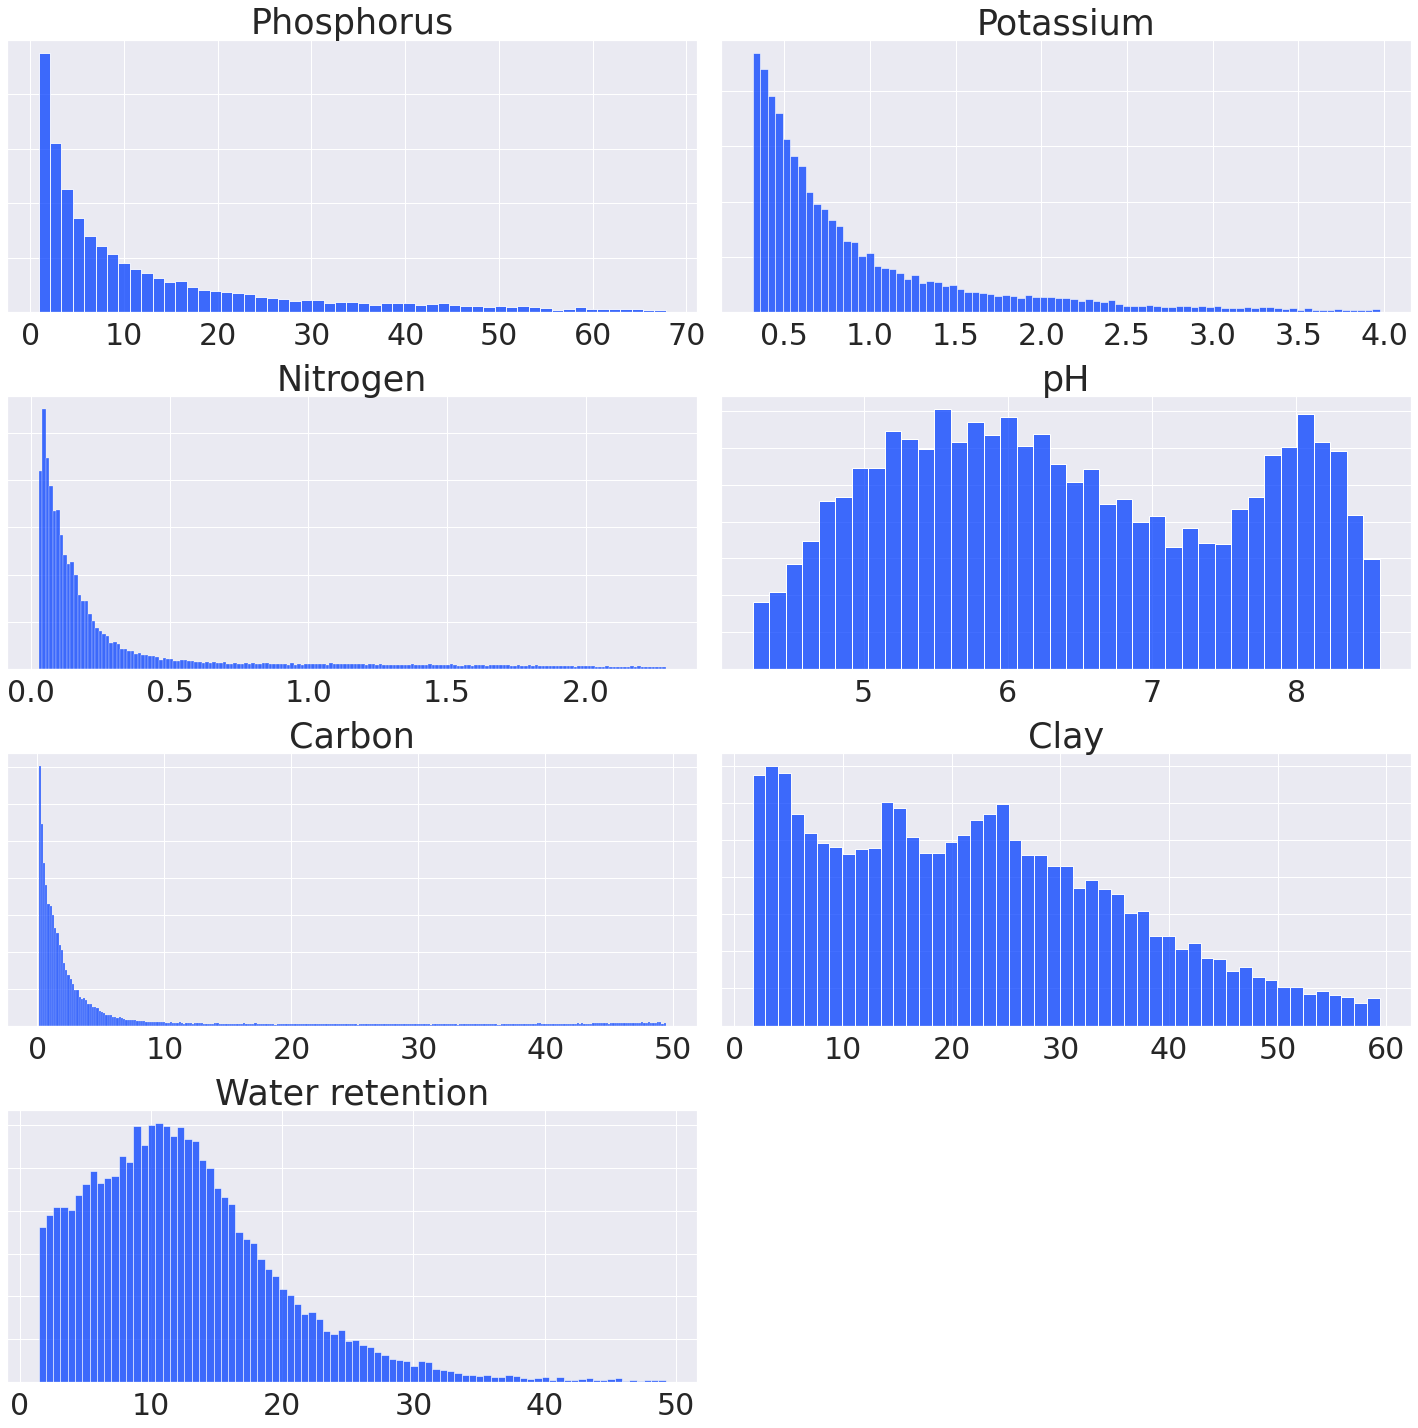

In [71]:
titles = ["Phosphorus", "Potassium", "Nitrogen", "pH", "Carbon", "Clay", "Water retention"]
fontsize=30
titlesize= 35

sns.set_style("darkgrid")
sns.set_palette("bright")

fig, axs = plt.subplots(4, 2, figsize=(20, 20))
for i, ax_list in enumerate(axs):
    for j, ax in enumerate(ax_list):
        try:
            index = j + i * len(axs[0])
            analyte = analytes[index]
            df = dfs[index]
            title = titles[index]
        except:
            fig.delaxes(ax)
            break
        df = drop_outliers_for_analyte(df, analyte, quantile=0.97)
        sns.histplot(data=df, x=analyte, ax=ax)
        ax.set_title(title, fontsize=titlesize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
#         ax.set(xticklabels=[])
        ax.set(yticklabels=[])

#         for label in ax.yaxis.get_ticklabels():
#             plt.setp(label, fontsize=fontsize)

        for label in ax.xaxis.get_ticklabels():
            plt.setp(label, fontsize=fontsize)
        
# fig.suptitle(suptitle, fontsize='24')
fig.tight_layout()

In [86]:
sis = pd.read_csv('/media/Data/sis_dataset/wetchem.csv')
sis

,id,pH,EC,OC,N,P,K,Zn,Cu,Fe,Mn,Sulphur,Boron
0,0,7.52,0.22,0.603093,213.248,20.05830,291.60,2.20,2.88,16.73,18.28,3.060,0.383208
1,1,6.92,0.20,0.654822,238.336,26.38036,259.20,0.36,1.24,28.88,28.22,17.225,0.475277
2,2,7.36,0.17,0.487310,188.160,8.45196,371.25,0.44,0.93,14.54,13.58,18.475,0.938112
3,3,6.96,0.17,0.525773,225.792,46.11870,411.75,0.56,3.44,19.21,26.50,5.875,0.826136
4,4,7.14,0.22,0.695876,238.336,22.11030,311.85,0.28,2.80,15.63,25.20,12.175,1.667202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,3178,8.30,0.20,0.558140,150.528,84.55680,270.00,2.16,1.74,22.28,14.26,50.375,0.614625
3179,3179,8.61,0.12,0.586047,163.072,61.21560,427.95,1.50,1.86,9.52,13.10,13.425,0.664392
3180,3180,8.30,0.18,0.572093,112.896,110.76060,137.70,0.90,1.20,10.68,11.46,11.775,0.689276
3181,3181,8.44,0.15,0.558140,150.528,26.64420,153.90,0.96,1.84,9.18,14.68,29.050,0.415556


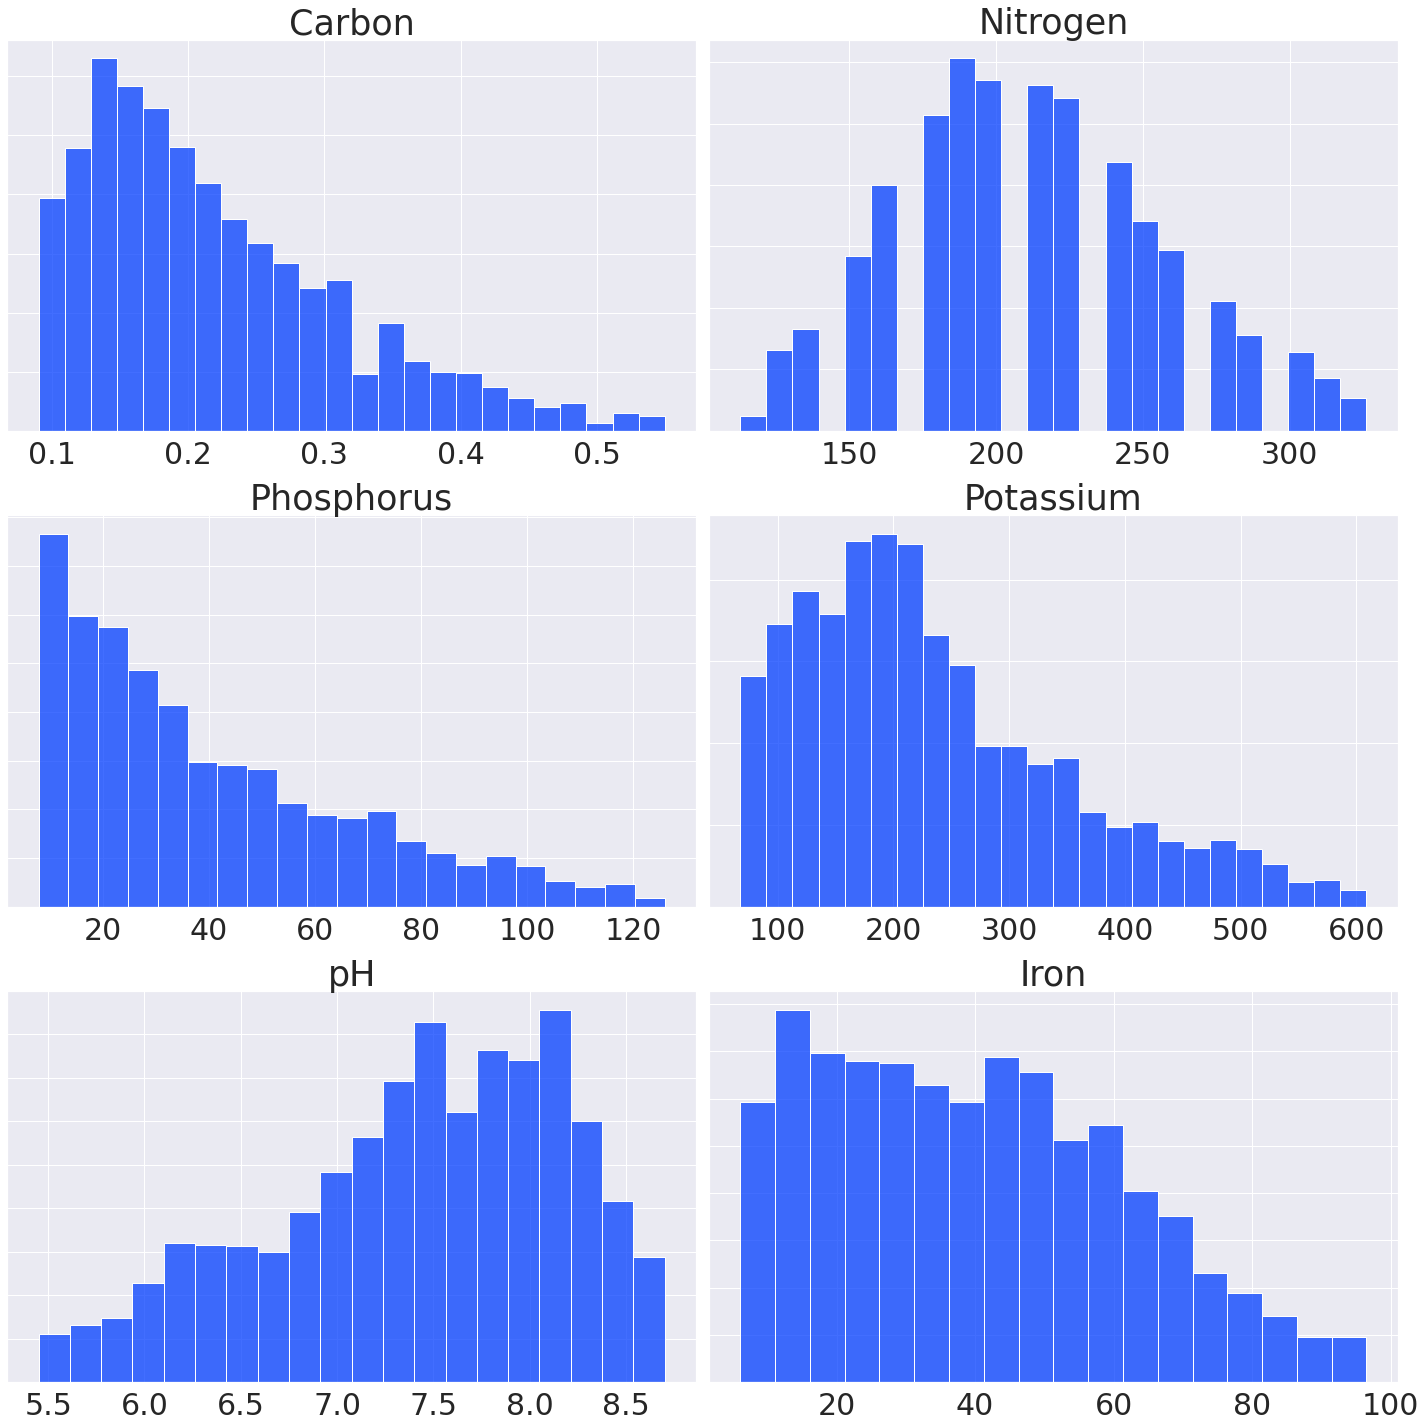

In [87]:
fontsize=30
titlesize= 35
analytes = ["EC", "N", "P", "K", "pH", "Fe"]
titles = ["Carbon", "Nitrogen", "Phosphorus", "Potassium", "pH", "Iron"]
sns.set_style("darkgrid")
sns.set_palette("bright")

fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i, ax_list in enumerate(axs):
    for j, ax in enumerate(ax_list):
        try:
            index = j + i * len(axs[0])
            analyte = analytes[index]
            title = titles[index]
        except:
            fig.delaxes(ax)
            raise
        sis = drop_outliers_for_analyte(sis, analyte, quantile=0.97)
        sns.histplot(data=sis, x=analyte, ax=ax)
        ax.set_title(title, fontsize=titlesize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
#         ax.set(xticklabels=[])
        ax.set(yticklabels=[])

#         for label in ax.yaxis.get_ticklabels():
#             plt.setp(label, fontsize=fontsize)

        for label in ax.xaxis.get_ticklabels():
            plt.setp(label, fontsize=fontsize)
        
# fig.suptitle(suptitle, fontsize='24')
fig.tight_layout()

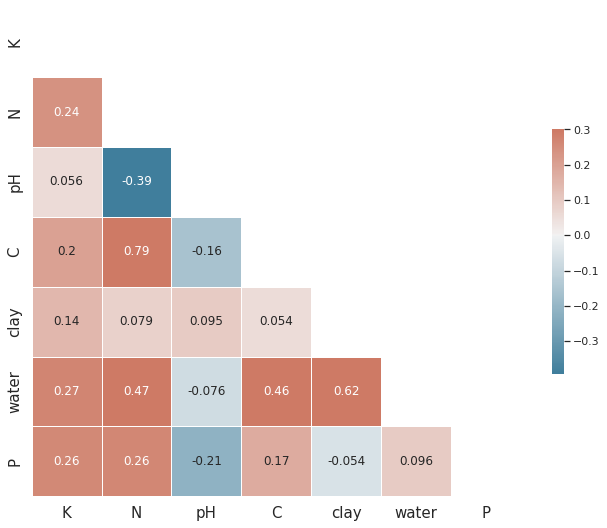

In [6]:

df = get_usda_wet_analytes(analytes)[analytes]

df["P"] = df["P2"]
df = df.drop(columns="P2")
corr = df.corr()
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

fontsize = 15
for label in ax.yaxis.get_ticklabels():
     plt.setp(label, fontsize=fontsize)

for label in ax.xaxis.get_ticklabels():
    plt.setp(label, fontsize=fontsize)

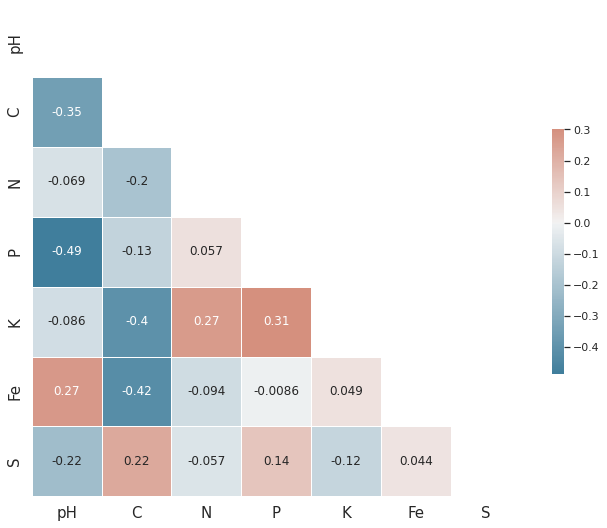

In [82]:
df = sis[["pH", "EC", "N", "P", "K", "Fe", "Sulphur"]]
df = df.rename(columns={"EC": "C", "Sulphur": "S"})
corr = df.corr()
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

fontsize = 15
for label in ax.yaxis.get_ticklabels():
     plt.setp(label, fontsize=fontsize)

for label in ax.xaxis.get_ticklabels():
    plt.setp(label, fontsize=fontsize)

In [50]:
usa_path = './geopandas-tutorial/data/usa-states-census-2014.shp'

world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

df = get_location_df()
states = gpd.read_file(usa_path)
df  = df[(df["lat_site"] >= 20) & (df["lat_site"] <= 50) & (df["long_site"] >= -140) & (df["long_site"] <= -60)]
sample_points = [Point(xy) for xy in zip(df['long_site'], df['lat_site'])]
sample_points_gdf = gpd.GeoDataFrame(geometry=sample_points)   




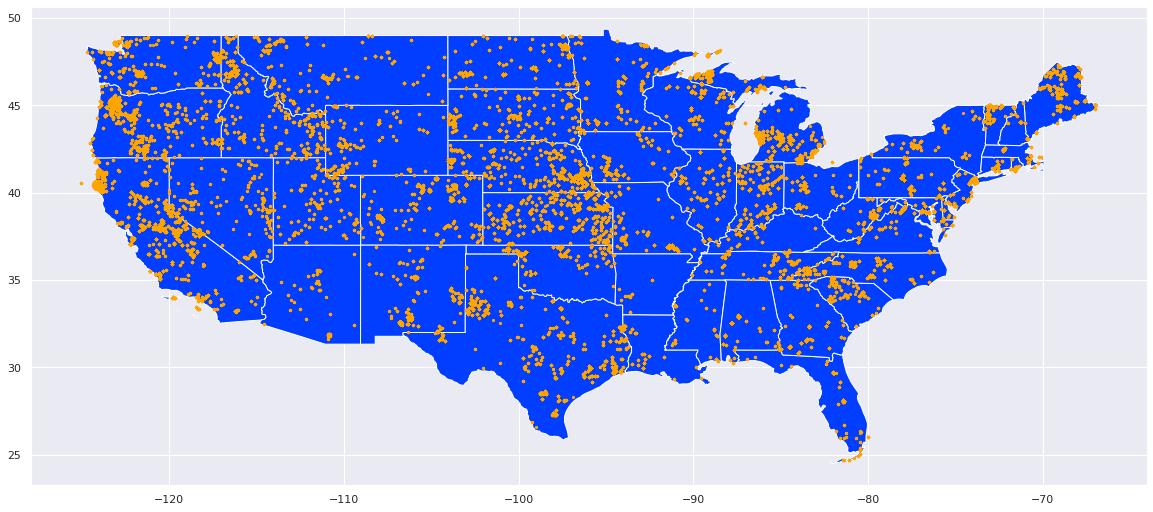

In [58]:
ax = states.plot(figsize=(20, 50))
# minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
# margin = 0.5
# ax.set_xlim(minx - margin, maxx + margin)
# ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color="orange", markersize=5)
fig.set_size_inches(18.5, 10.5)

In [101]:
P2df = get_usda_analyte_df(usda_analytes + ["location"])

getting cached cache/prod/get_usda_analyte_df/P2,K,N,pH,C,clay,water,location##113453fd990c42c70a493b7313d11dabad781118da343e25f679f9af0c5363fc


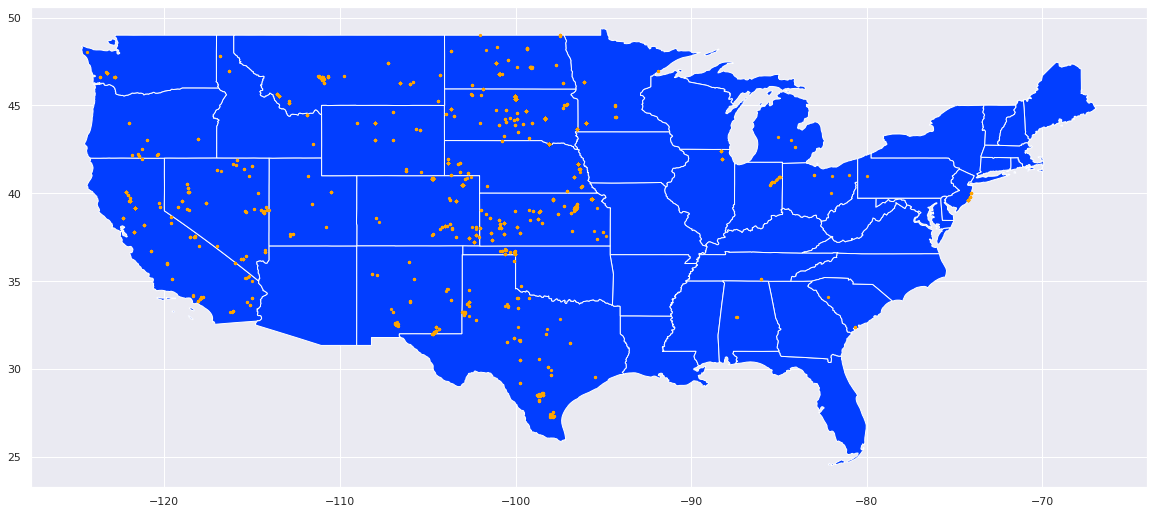

In [102]:
usa_path = './geopandas-tutorial/data/usa-states-census-2014.shp'

world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

df = P2df
states = gpd.read_file(usa_path)
df  = df[(df["lat_site"] >= 20) & (df["lat_site"] <= 50) & (df["long_site"] >= -140) & (df["long_site"] <= -60)]
sample_points = [Point(xy) for xy in zip(df['long_site'], df['lat_site'])]
sample_points_gdf = gpd.GeoDataFrame(geometry=sample_points) 
ax = states.plot(figsize=(20, 50))
# minx, miny, maxx, maxy = gpd.GeoSeries(sample_points).total_bounds
# margin = 0.5
# ax.set_xlim(minx - margin, maxx + margin)
# ax.set_ylim(miny - margin, maxy + margin)


sample_points_gdf.plot(ax=ax, marker='o', color="orange", markersize=5)
fig.set_size_inches(18.5, 10.5)

In [110]:
us = get_usda_wet_analyte("N")
us = drop_outliers_for_analyte(us, "N", quantile=0.99)
skew(us["N"])

2.3097851601708004

In [109]:
us = get_usda_wet_analyte("C")
us = drop_outliers_for_analyte(us, "C")
skew(us["C"])

2.32197371986651

In [114]:
n = drop_outliers_for_analyte(sis, "N")
skew(n["N"])

0.299597772803421

In [115]:
e  = drop_outliers_for_analyte(sis, "EC")

skew(e["EC"])

0.7906236184468629

In [119]:
get_usda_analyte_df("N")

getting cached cache/prod/get_usda_analyte_df/N##8ce86a6ae65d3692e7305e2c58ac62eebd97d3d943e093f577da25c36988246b


,smp_id,N,4001.65608,3999.72758,3997.79907,3995.87056,3993.94205,3992.01354,3990.08503,3988.15652,...,617.12287,615.19436,613.26585,611.33734,609.40883,607.48032,605.55181,603.6233,601.69479,599.76629
53445,214755,0.121252,0.22513,0.22542,0.22570,0.22598,0.22629,0.22662,0.22695,0.22726,...,1.62661,1.62265,1.61831,1.61149,1.60241,1.59142,1.57969,1.56951,1.56315,1.56021
3036,120828,0.030228,0.39603,0.39615,0.39606,0.39584,0.39579,0.39586,0.39607,0.39647,...,1.77166,1.77261,1.77115,1.76561,1.75766,1.74892,1.73868,1.72801,1.72012,1.71625
32359,285345,0.040052,0.22036,0.22046,0.22057,0.22066,0.22071,0.22076,0.22082,0.22086,...,1.27660,1.28219,1.28792,1.29364,1.29824,1.30059,1.30170,1.30316,1.30567,1.30975
48699,97555,0.279350,0.29517,0.29571,0.29625,0.29677,0.29732,0.29783,0.29831,0.29880,...,1.80976,1.79991,1.78809,1.77505,1.76091,1.74663,1.73303,1.71945,1.70576,1.69229
12674,231887,0.223829,0.13783,0.13819,0.13852,0.13881,0.13909,0.13935,0.13966,0.13997,...,1.57049,1.56721,1.56228,1.55504,1.54605,1.53576,1.52570,1.51682,1.50965,1.50437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50606,209998,0.154510,0.34234,0.34273,0.34306,0.34330,0.34355,0.34383,0.34410,0.34432,...,1.55341,1.54125,1.52984,1.51779,1.50612,1.49589,1.48641,1.47803,1.47047,1.46196
13967,227922,0.053816,0.22823,0.22869,0.22908,0.22939,0.22972,0.23008,0.23047,0.23089,...,1.50272,1.49013,1.47976,1.46745,1.45071,1.43193,1.41415,1.39888,1.38657,1.37713
27701,229086,0.335757,0.18308,0.18349,0.18386,0.18416,0.18446,0.18477,0.18512,0.18549,...,1.55932,1.55890,1.55743,1.55376,1.54836,1.54274,1.53700,1.53036,1.52430,1.52105
2988,174427,2.563114,0.48114,0.48125,0.48134,0.48146,0.48164,0.48176,0.48186,0.48199,...,1.63179,1.63275,1.63258,1.63088,1.62942,1.62794,1.62529,1.62295,1.62254,1.62293
